# GEO877: Spatial Algorithms - Haklay



In [1]:
from geospatial import *
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString, mapping, MultiLineString
from pathlib import Path
import matplotlib.pyplot as plt

## Classes and functions

In [2]:
# Define class to store attributes with each motorway segment
class MotorwaySegment(Segment):
    def __init__(self, start, end, name=str(), source=str(), crs=str()):
        super().__init__(start, end)
        self.name = name
        self.source = source
        self.crs = crs
    
    # Overwrite representation
    def __repr__(self):
        return f'MotorwaySegment of "{self.name}" with start {self.start} and end {self.end}.' 
    
    def plot_seg(self):
        xs = [self.start.x, self.end.x]
        ys = [self.start.y, self.end.y]
        plt.plot(xs, ys)

def linestring_to_coords(line):
    """ 
    !Requires shapely.geometry.mapping()!
    https://stackoverflow.com/questions/62053253/how-to-split-a-linestring-to-segments
        
    Creates a tuple of tuples containing x-, y-coordinates from a shapely.geometry.LineString() object.
    """
    # Create dictionary of attributes of LineString object
    mp = mapping(line)
    # Extracts coordinate tuples into a list
    t_tuples = mp['coordinates']
    return t_tuples

def coords_to_point_list(coords):
    """
    Creates list of list of geospatial.Point() objects pairs from coord list.
    """
    point_list = []
    for coord_pair in coords:
        point_list.append(Point(coord_pair[0], coord_pair[1]))
    return point_list

In [3]:
# Transformation function based on pyproj Transformer
from pyproj import Transformer

def transform_segments(segments, from_crs='epsg:4326', to_crs='epsg:2056'):
    transformer = Transformer.from_crs(from_crs, to_crs)
    transformed_segments = []
    for segment in segments:
        start = segment.start
        end = segment.end
        name = segment.name
        source = segment.source
        crs = segment.crs
        start_transformed = transformer.transform(start.y, start.x)
        end_transformed = transformer.transform(end.y, end.x)
        transformed_segment = MotorwaySegment(Point(*start_transformed), Point(*end_transformed), name, source, to_crs)
        transformed_segments.append(transformed_segment)
    return transformed_segments

In [10]:
class MotorwayLine():
    #initialise
    def __init__(self, data=None, xcol=None, ycol=None): #data = list of segments from the same street
        self.segments = []
        self.name = data[0].name
        self.points = []
        for d in data:
            #add segment
            self.segments.append(d)
            #add points - there will be duplicates /!\
            self.points.append(d.start)
            self.points.append(d.end)
    
    def __len__(self):
        return len(self.segments)
    
    def removeDuplicates(self):
        oldn = len(self.points)
        self.points = list(dict.fromkeys(self.points)) # Get rid of the duplicates
        n = len(self.points)
        print(f'The old line had {oldn} points, now we only have {n}.')
        return self
        
    
    def bbox(self):
        x = [i.x for i in self.points]   # extract all x coords as a list
        y = [i.y for i in self.points]   # extract all y coords as a list

        # determine corners, calculate centre and area
        self.ll = Point(min(x), min(y))    # lower-left corner (min x, min y)
        self.ur = Point(max(x), max(y))    # upper-right corner (max x, max y)
        self.ctr = Point((max(x)-min(x))/2, (max(y)-min(y))/2)   # centre of box
        self.area = (abs(max(x)-min(x)))*abs((max(y)-min(y)))    # area of box
        print(f'Bounding box with lower-left {self.ll} and upper-right {self.ur}' )
        return self.ll, self.ur
    
    def plot_bbox(self):
        ll, ur = self.bbox()
        plt.plot([ll.x, ll.x, ur.x, ur.x, ll.x], [ll.y, ur.y, ur.y, ll.y, ll.y], linestyle='dashed')

    def plot_seg(self):
        for seg in self.segments:
            seg.plot_seg()
    
    def plot_seg2(self):
        xs = []
        ys = []
        for seg in self.segments:
            xs.append(seg.start.x)
            xs.append(seg.end.x)
            ys.append(seg.start.y)
            ys.append(seg.end.y)

        plt.plot(xs, ys)
        
        
     # Overwrite representation
    def __repr__(self):
        return f'MotorwayLine "{self.name}" has "{len(self.segments)}" segments, and "{len(self.points)}" points.'    


#exemple_line = MotorwayLine([motorway_ch_segments[0], motorway_ch_segments[1]])
#print(exemple_line)
#exemple_line.removeDuplicates()
#exemple_line.bbox()
#exemple_line.plot_seg()
#exemple_line.plot_bbox()

## OSM

### Download data

<Axes: >

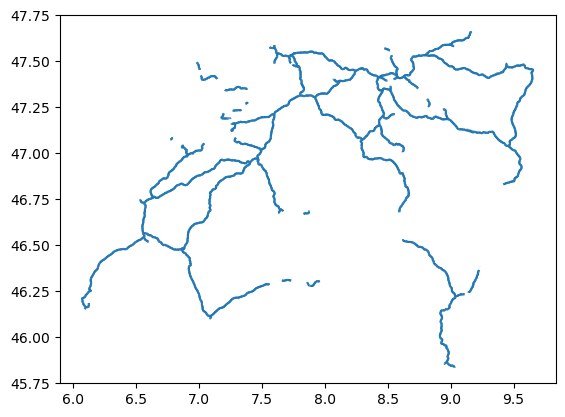

In [5]:
# Download OSM Data to GeoDataFrame()
tags = {"highway":"motorway"}
motorway_file_path = Path(r"./data/motorways_osm.geojson")
if motorway_file_path.is_file():
    motorways = gpd.read_file(motorway_file_path)
else:
    # Use ox package to download geometries from
    import osmnx as ox
    motorways = ox.geometries_from_place("Switzerland",tags=tags)
    # Convert lists to strings for GeoJSON
    motorways = motorways.apply(lambda col: col.astype(str) if isinstance(col[0], list) else col)
    motorways.to_file(motorway_file_path, "GeoJSON")
motorways.plot()

### Class MotorwaySegment

In [6]:
mway_geometries = motorways.geometry
nested_coords = [linestring_to_coords(line_geom) for line_geom in mway_geometries if type(line_geom)==type(LineString())]
nested_points = [coords_to_point_list(coord_list) for coord_list in nested_coords]
motorways["points"] = nested_points

motorway_segments = []
for index, row in motorways.iterrows():
    name = row['ref']
    points = row['points']
    for i in range(len(points)-1):
        start = points[i]
        end = points[i+1]
        source = "osm"
        crs = 'epsg:4326'
        segment = MotorwaySegment(start, end, name, source, crs)
        motorway_segments.append(segment)

In [7]:
# Example 4326 to 2056
motorway_segments_transformed = transform_segments(motorway_segments,
                                                   from_crs='epsg:4326', to_crs='epsg:2056')
print(f"{motorway_segments[0]} \t {motorway_segments[0].crs}",
      f"{motorway_segments_transformed[0]} \t {motorway_segments_transformed[0].crs}", sep="\n")

MotorwaySegment of "A2" with start Point(x=8.9287827, y=46.0685891) and end Point(x=8.928685, y=46.0680586). 	 epsg:4326
MotorwaySegment of "A2" with start Point(x=2715295.589739048, y=1102990.6704969718) and end Point(x=2715289.151463621, y=1102931.5637740807). 	 epsg:2056


### Class MotorwayLine

In [8]:
#create the lines dataset from the segments

#find the streetnames
streetnames_osm = []
for segment in motorway_segments:
    streetname = segment.name
    if streetname not in streetnames_osm: 
        streetnames_osm.append(streetname)
print(len(streetnames_osm))

42


In [11]:
motorway_osm_lines = []
for streetname in streetnames_osm:
    list_segments = []
    for segment in motorway_segments:
        #find all segments of the streetname and put them in a list
        if segment.name == streetname:
            list_segments.append(segment)
    if len(list_segments) > 0:
        #create the line from the list
        motorwayLine = MotorwayLine(list_segments)
        #add the street to the motorway_lines dataset
        motorway_osm_lines.append(motorwayLine)    
        
print(motorway_osm_lines[0])

len(motorway_osm_lines)

MotorwayLine "A2" has "8667" segments, and "17334" points.


41

### Data exploration

In [12]:
motorway_osm_lines[0].segments[0:10]

[MotorwaySegment of "A2" with start Point(x=8.9287827, y=46.0685891) and end Point(x=8.928685, y=46.0680586).,
 MotorwaySegment of "A2" with start Point(x=8.928685, y=46.0680586) and end Point(x=8.9285885, y=46.0675395).,
 MotorwaySegment of "A2" with start Point(x=8.9285885, y=46.0675395) and end Point(x=8.9283194, y=46.0664303).,
 MotorwaySegment of "A2" with start Point(x=8.9283194, y=46.0664303) and end Point(x=8.9281726, y=46.0658727).,
 MotorwaySegment of "A2" with start Point(x=8.9850186, y=45.9162338) and end Point(x=8.9850653, y=45.9157003).,
 MotorwaySegment of "A2" with start Point(x=8.9850653, y=45.9157003) and end Point(x=8.9850673, y=45.9151684).,
 MotorwaySegment of "A2" with start Point(x=8.9850673, y=45.9151684) and end Point(x=8.9850138, y=45.9147816).,
 MotorwaySegment of "A2" with start Point(x=8.9850138, y=45.9147816) and end Point(x=8.9849448, y=45.9143919).,
 MotorwaySegment of "A2" with start Point(x=8.9849448, y=45.9143919) and end Point(x=8.984852, y=45.914050

1390


<Axes: >

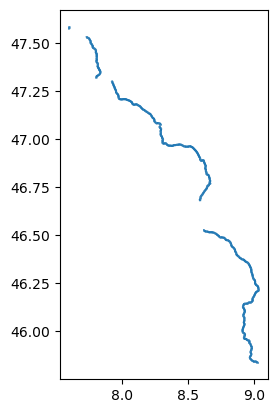

In [13]:
# PLOT FROM ORIGINAL GEOMETRY
print(len(motorways[motorways["ref"] == "A2"]))
motorways[motorways["ref"] == "A2"].plot()

MotorwayLine "A2" has "8667" segments, and "17334" points.
The old line had 17334 points, now we only have 8676.
Bounding box with lower-left Point(x=7.5989105, y=45.8387166) and upper-right Point(x=9.0371186, y=47.5862612)


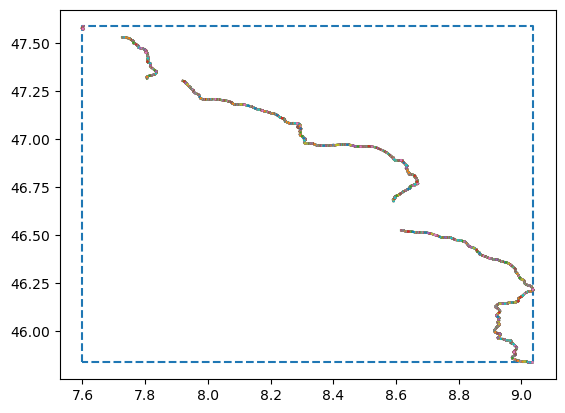

In [14]:
# PLOT A2
print(motorway_osm_lines[0])
motorway_osm_lines[0].removeDuplicates()
motorway_osm_lines[0].plot_bbox()
motorway_osm_lines[0].plot_seg()

## Swissdataset: Astra national roads

### Download data
Download data from:  
https://data.geo.admin.ch/browser/index.html#/collections/ch.astra.nationalstrassenachsen/items/nationalstrassenachsen?.language=en&.asset=asset-nationalstrassenachsen_2056.gdb.zip 


<Axes: >

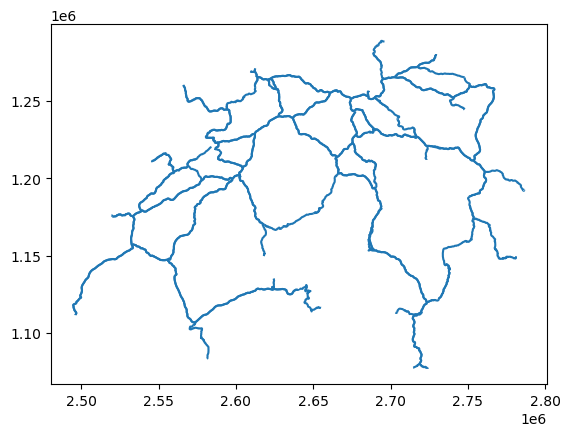

In [22]:
#import .gdb
import fiona
fiona.listlayers(Path(r"data/national_roads/ch.astra.nationalstrassenachsen.gdb"))
motorways_ch = gpd.read_file(Path(r"data/national_roads/ch.astra.nationalstrassenachsen.gdb"), driver='FileGDB', layer='Stammachsen')
motorways_ch.plot()

In [23]:
motorways_ch

,ID,Eigentuemer,Segmentname,Strassennummer,Bezeichnung,Positionscode,SHAPE_Length,geometry
0,{CFE92388-BFC8-4BE9-ACA6-77B507A0ECBA},CH,3. Röhre Belchen,N2BEL,N2 3. Röhre Belchen,=,3523.150899,MULTILINESTRING Z ((2628517.644 1247691.706 0....
1,{84E9F264-BD08-4293-9A70-130000145312},CH,ZÜRICH-NORD - Kloten-Süd,N11,Zürich - Kloten,+,3608.788116,MULTILINESTRING Z ((2685576.594 1253439.725 42...
2,{AA4CFACD-7C6E-4BB3-A789-1954D7D3162D},CH,Angenstein - Basel,N18,Delémont - Basel,+,7173.420712,MULTILINESTRING Z ((2612371.830 1258978.196 0....
3,{E3F350B9-C4DC-4640-92A9-ACD40E3D0BF6},CH,Angenstein - Basel,N18,Delémont - Basel,-,7183.502921,MULTILINESTRING Z ((2612369.777 1258977.982 0....
4,{70F7FD65-257C-E74A-90B3-29884344F0FB},CH,Liestal-Süd - Sissach,N22,Pratteln - Sissach,-,4498.729666,MULTILINESTRING Z ((2623239.356 1259010.510 0....
...,...,...,...,...,...,...,...,...
160,{8DB04275-2437-42A6-8431-29175A2F14D0},CH,Därligen-West - Därligen-Ost,N8,SPIEZ - LOPPER,+,2152.310189,MULTILINESTRING Z ((2627661.910 1167992.480 0....
161,{D104459F-18AF-4468-BE55-6E5DF40DCDEF},CH,Niderstad,N8,SPIEZ - LOPPER,+,1629.023405,MULTILINESTRING Z ((2664221.400 1201220.141 43...
162,{5999D5D5-8E60-4EE2-81DF-A8BDDC3428D3},CH,Interlaken-West - Interlaken-Ost,N8,SPIEZ - LOPPER,+,4419.090816,MULTILINESTRING Z ((2630622.350 1168868.650 0....
163,{18421F37-AE6D-415F-AED9-0650CC71ADF0},CH,BLEGI - Baar,N14,Luzern - Wädenswil,-,8096.237477,MULTILINESTRING Z ((2677815.381 1227877.377 42...


### Class MotorwaySegment

In [36]:
#extract geometries
print(motorways_ch["geometry"].geom_type.unique())
mway_ch_geometries = motorways_ch.geometry

#convert multilines to line
mway_ch_geometries_exp = mway_ch_geometries.explode(index_parts=True)
mway_ch_geometries_exp

['MultiLineString']


0    0    LINESTRING Z (2628517.644 1247691.706 0.000, 2...
1    0    LINESTRING Z (2685576.594 1253439.725 424.735,...
2    0    LINESTRING Z (2612371.830 1258978.196 0.000, 2...
3    0    LINESTRING Z (2612369.777 1258977.982 0.000, 2...
4    0    LINESTRING Z (2623239.356 1259010.510 0.000, 2...
                                ...                        
160  0    LINESTRING Z (2627661.910 1167992.480 0.000, 2...
161  0    LINESTRING Z (2664221.400 1201220.141 436.160,...
162  0    LINESTRING Z (2630622.350 1168868.650 0.000, 2...
163  0    LINESTRING Z (2677815.381 1227877.377 428.230,...
164  0    LINESTRING Z (2663478.966 1256666.540 435.230,...
Name: geometry, Length: 165, dtype: geometry

In [25]:
nested_coords_ch = [linestring_to_coords(line_geom) for line_geom in mway_ch_geometries_exp if type(line_geom)==type(LineString())]
nested_points_ch = [coords_to_point_list(coord_list) for coord_list in nested_coords_ch]
motorways_ch["points"] = nested_points_ch

In [26]:
#create the Segments dataset from the datasets
motorway_ch_segments = []
for index, row in motorways_ch.iterrows():
    name = row['Strassennummer']
    points = row['points']
    for i in range(len(points)-1):
        start = points[i]
        end = points[i+1]
        source = "astra"
        crs = 'epsg:2056'
        segment = MotorwaySegment(start, end, name, source, crs)
        motorway_ch_segments.append(segment)

### Class MotorwayLine

In [27]:
#create the Lines dataset from the segments

#find the streetnames
streetnames_ch = []
for segment in motorway_ch_segments:
    streetname = segment.name
    if streetname not in streetnames_ch: 
        streetnames_ch.append(streetname)
print(len(streetnames_ch))

28


In [28]:
motorway_ch_lines = []
for streetname in streetnames_ch:
    list_segments = []
    for segment in motorway_ch_segments:
        #find all segments of the streetname and put them in a list
        if segment.name == streetname:
            list_segments.append(segment)
    #create the line from the list
    motorwayLine = MotorwayLine(list_segments)
    #add the street to the motorway_ch_lines dataset
    motorway_ch_lines.append(motorwayLine)    
        
print(motorway_ch_lines[0])

len(motorway_ch_lines)

MotorwayLine "N2BEL" has "66" segments, and "132" points.


28

### Data exploration

In [29]:
for motorway in motorway_ch_lines:
    if motorway.name == 'N2':
        N2 = motorway

N2.segments[0:10]

[MotorwaySegment of "N2" with start Point(x=2636613.189086914, y=1239075.271118164) and end Point(x=2636665.1467285156, y=1239031.8137207031).,
 MotorwaySegment of "N2" with start Point(x=2636665.1467285156, y=1239031.8137207031) and end Point(x=2636691.6049194336, y=1239009.3242797852).,
 MotorwaySegment of "N2" with start Point(x=2636691.6049194336, y=1239009.3242797852) and end Point(x=2636719.519104004, y=1238985.6436767578).,
 MotorwaySegment of "N2" with start Point(x=2636719.519104004, y=1238985.6436767578) and end Point(x=2636740.950317383, y=1238966.7265014648).,
 MotorwaySegment of "N2" with start Point(x=2636740.950317383, y=1238966.7265014648) and end Point(x=2636765.688293457, y=1238943.9721069336).,
 MotorwaySegment of "N2" with start Point(x=2636765.688293457, y=1238943.9721069336) and end Point(x=2636785.3994750977, y=1238924.7907104492).,
 MotorwaySegment of "N2" with start Point(x=2636785.3994750977, y=1238924.7907104492) and end Point(x=2636809.6094970703, y=1238900.

8


<Axes: >

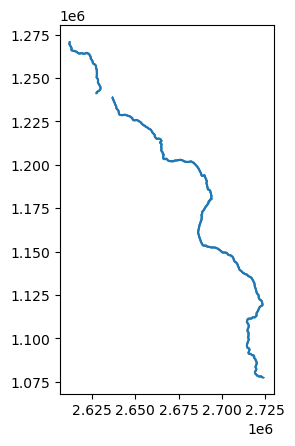

In [30]:
# PLOT A2 FROM ORIGINAL GEOMETRY
print(len(motorways_ch[motorways_ch["Strassennummer"] == "N2"]))
motorways_ch[motorways_ch["Strassennummer"] == "N2"].plot()

MotorwayLine "N2" has "17396" segments, and "34792" points.
The old line had 34792 points, now we only have 17086.
Bounding box with lower-left Point(x=2612063.33392334, y=1077604.9141235352) and upper-right Point(x=2724111.5220947266, y=1271123.8577270508)


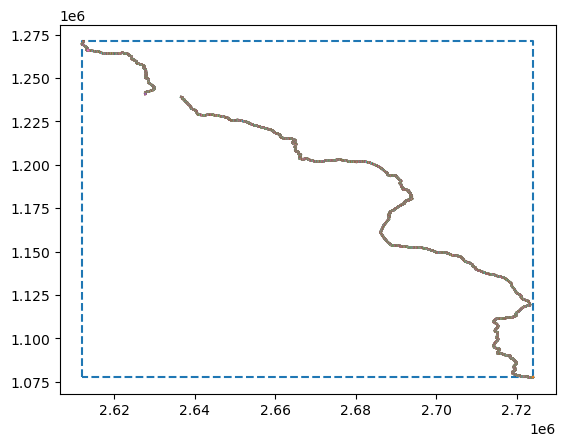

In [31]:
# PLOT A2 FROM MOTORWAY LINES
print(N2)
N2.removeDuplicates()
N2.plot_bbox()
N2.plot_seg()

## Datasets comparison

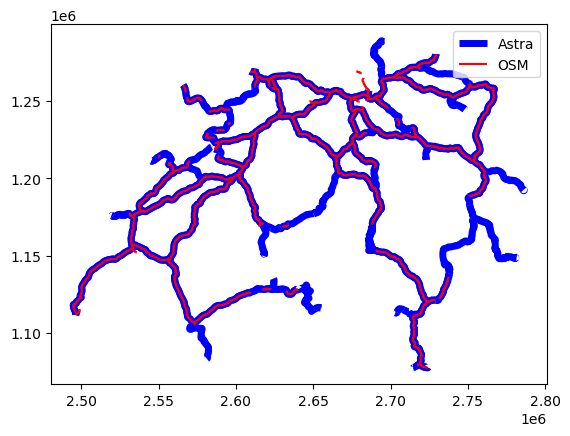

In [32]:
fig, ax = plt.subplots()

#ASTRA
motorways_ch.plot(ax=ax, color = "blue", label = "Astra",  linewidth = 5)

#OSM
motorways.to_crs(epsg = 2056).plot(ax=ax, color = "red", label = "OSM")
plt.legend()

Text(0.5, 1.0, 'N2')

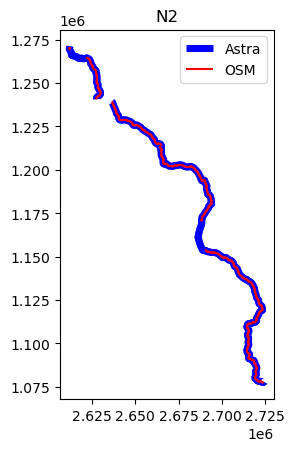

In [33]:
fig, ax = plt.subplots()

#ASTRA
motorways_ch[motorways_ch["Strassennummer"] == "N2"].plot(ax=ax, color = "blue", label = "Astra",  linewidth = 5)

#OSM
motorways[motorways["ref"] == "A2"].to_crs(epsg = 2056).plot(ax=ax, color = "red", label = "OSM")

plt.legend()
plt.title("N2")

In [34]:
streetnames_ch

['N2BEL',
 'N11',
 'N18',
 'N22',
 'N17',
 'N23',
 'N24',
 'N13',
 'N21',
 'N14',
 'N8',
 'N25',
 'N2P',
 'N28',
 'N15',
 'N7',
 'N5',
 'N6',
 'N12',
 'N16',
 'N20',
 'N9',
 'N4',
 'N29',
 'N1',
 'N2',
 'N3',
 'N1BAR']

In [35]:
streetnames_osm

['A2',
 'A24',
 'A9;A 2',
 'A9',
 'A13',
 'A4',
 'A1;A4',
 'A3',
 'A15',
 'A1L',
 'A14',
 '53',
 'A1',
 'A11',
 'A7',
 'A51',
 'A23',
 'A1H',
 'A1R;5',
 'A3;A4',
 'A3W',
 'A1;A2',
 '32',
 'A50',
 'A1;A3',
 '7;A50',
 'A1;A6',
 'A6',
 'A8',
 nan,
 'A12',
 'A16',
 'A5',
 'A22',
 'A18',
 'A2;A3',
 'A21',
 'A1a',
 'A1;A9',
 'A20',
 'A20;20',
 'A 16']